# Layer-wise parameterization of LRU
Parameterization of the learning rate and the standard deviation of the initial weights.

In [5]:
import data_transformation
import layer_parameterisation
import final_model_layer
import data_transformation
import random
import optax
from flax import nnx
import tensorflow as tf 
import jax.numpy as jnp  # JAX NumPy
import numpy as np

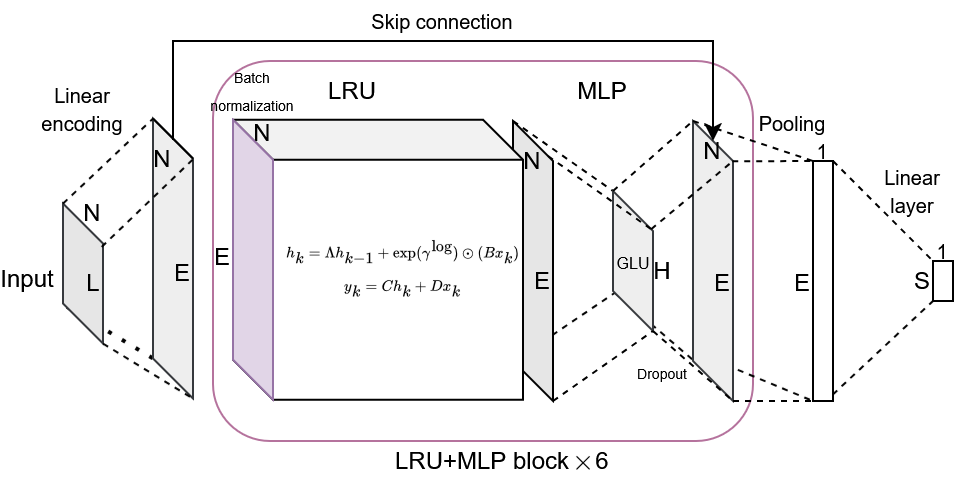

In [6]:
#Scheme of the model
from IPython.display import Image, display
display(Image(filename="lru.png"))

In [ ]:
pool=1 #pooling layer after MLP is taking the average over the numbers
trans_to_8bit=0 #transformation of the data from decimals between 0 and 256 to binary 8 bit numbers
leave_data=1 #download csv data of the results

hidden_neuron=384 #H in the scheme
encoded_size=512 #E in the scheme
hidden_size=384 #N in the scheme

r_min = 0.9
r_max = 0.999
max_phase = 6.28

learning_rate = 1e-3
momentum = 0.9
train_steps=30000
eval_every = 50
batch_size=50

depth=6
lr_factor=0.25
dropout=0.1
method_name="LRUMLP6"

dataset_name="MNIST" #MNIST or CIFAR10

folder_name=""
rand=random.randint(0,10000)
rngs1=nnx.Rngs(rand)
print(rand)

In [ ]:
train, test, train_x, train_x_size, train_x_len, test_x, test_x_len, test_x_seq, train_y, train_y_class, test_y = data_transformation.data_transformation(dataset_name, trans_to_8bit)

train_ds=tf.data.Dataset.from_tensor_slices((jnp.real(train_x),jnp.array(train_y,dtype=int)))
test_ds=tf.data.Dataset.from_tensor_slices((jnp.real(test_x),jnp.array(test_y,dtype=int)))

train_ds = train_ds.repeat().shuffle(100)

# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
#following Lénaïc Chizat and Praneeth Netrapalli. The feature speed formula: a flexible approach to scale hyper-parameters of deep neural networks, 2024. URL https://arxiv.org/abs/2311.18718.
lin_encoder_lr,lin_encoder_sigma=layer_parameterisation.compute_lr_sigma(mode="input",d=train_x_size,m=encoded_size,k=0,L=1)
MLP1_lr,MLP1_sigma=layer_parameterisation.compute_lr_sigma("hidden",encoded_size,hidden_neuron//2,0,1)
MLP2_lr,MLP2_sigma=layer_parameterisation.compute_lr_sigma("output",0,hidden_neuron//2,encoded_size,1)
out_lr,out_sigma=layer_parameterisation.compute_lr_sigma("output",encoded_size,encoded_size,train_y_class,1)


In [ ]:
model = final_model_layer.LRUMLP_layer(
    train_x_size,
    train_x_len,
    encoded_size,
    hidden_size,
    hidden_neuron,
    train_y_class,
    r_min, 
    r_max, 
    max_phase, 
    dropout, 
    pool,
    lin_encoder_sigma,
    MLP1_sigma,
    MLP2_sigma,
    out_sigma,
    rngs=rngs1,
)

In [ ]:
param = nnx.state(model,nnx.Param).flat_state()
gr=data_transformation.group_tuples_to_nested_dict(list(param.keys()))

In [ ]:

#Set optimization method per layer
rnn_schedule=optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor)
lin_schedule=optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7)
lin_encoder_schedule=optax.warmup_cosine_decay_schedule(init_value=1e-7*lin_encoder_lr, peak_value=learning_rate*lin_encoder_lr, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lin_encoder_lr)
MLP1_schedule=optax.warmup_cosine_decay_schedule(init_value=1e-7*MLP1_lr, peak_value=learning_rate*MLP1_lr, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*MLP1_lr)
MLP2_schedule=optax.warmup_cosine_decay_schedule(init_value=1e-7*MLP2_lr, peak_value=learning_rate*MLP2_lr, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*MLP2_lr)
out_schedule=optax.warmup_cosine_decay_schedule(init_value=1e-7*out_lr, peak_value=learning_rate*out_lr, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*out_lr)

#lr factor only on A and B so C,D same as the linear layers -> although going up slower, less overfitting -> why?
#No sensitive fitting -> less overfitting?
d={"B_re":optax.adamw(rnn_schedule),
   "B_im":optax.adamw(rnn_schedule),
    'C_im': optax.adamw(lin_schedule,weight_decay=0.05),
    'C_re': optax.adamw(lin_schedule,weight_decay=0.05),
    'D': optax.adamw(lin_schedule,weight_decay=0.05),
    'gamma_log': optax.adamw(rnn_schedule),
    'nu_log': optax.adamw(rnn_schedule),
    'theta_log': optax.adamw(rnn_schedule),

    #if linear3 not pooling
    'kernel':optax.adamw(lin_schedule,weight_decay=0.05),
    'bias':optax.adamw(lin_schedule,weight_decay=0.05),

     "lin_encoder_kernel": optax.adamw(lin_encoder_schedule,weight_decay=0.05),
     "MLP1_kernel": optax.adamw(MLP1_schedule,weight_decay=0.05),
     "MLP2_kernel": optax.adamw(MLP2_schedule,weight_decay=0.05),
     "out_kernel": optax.adamw(out_schedule,weight_decay=0.05),

     "lin_encoder_bias": optax.adamw(lin_encoder_schedule,weight_decay=0.05),
     "MLP1_bias": optax.adamw(MLP1_schedule,weight_decay=0.05),
     "MLP2_bias": optax.adamw(MLP2_schedule,weight_decay=0.05),
     "out_bias": optax.adamw(out_schedule,weight_decay=0.05),

     "scale": optax.adamw(lin_schedule,weight_decay=0.05),
     }

tx=optax.multi_transform(d,nnx.State(gr))

optimizer = nnx.Optimizer(model, tx)
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss"),)

In [ ]:
def loss_fn(model: final_model_layer.LRUMLP_layer, batch):
  logits = model(batch[0])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch[1]
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: final_model_layer.LRUMLP_layer, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn,has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.
  optimizer.update(grads)  # In-place updates.


@nnx.jit
def eval_step(model: final_model_layer.LRUMLP_layer, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.

In [ ]:
#Train the model + evaluation with the test data
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(
      f"[train] step: {step}       , "
      f"loss: {metrics_history['train_loss'][-1]}      , "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}     "
    )
    print(
      f"[test] step: {step}        , "
      f"loss: {metrics_history['test_loss'][-1]}       , "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}      "
    )

In [ ]:
#Save the training results into csv
import pandas as pd

if leave_data:
    data=pd.DataFrame({"step":np.arange(eval_every,train_steps+eval_every,eval_every),"train_loss":metrics_history['train_loss'],
                       "test_loss":metrics_history['test_loss'],"train_accuracy":metrics_history['train_accuracy'],
                       "test_accuracy":metrics_history['test_accuracy']})
    data.to_csv("/content/drive/My Drive/PDM_outputs/"+folder_name+"/"+method_name+"_H"+str(encoded_size)+"_nr"+str(hidden_neuron)+"_D"+str(hidden_size)+"_"+dataset_name+"_lr"+str(learning_rate)+"_step"+str(train_steps)+"r_min_"+str(r_min)+"r_max"+str(r_max)+"_rand"+str(rand)+".csv")

#Plot the loss
import matplotlib.pyplot as plt

plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['train_loss'],label="train loss")
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['test_loss'],label="test loss")
plt.title("Train loss of "+dataset_name+" dataset with "+method_name+
              ", \nhidden dimension="+str(hidden_size)+", number of neuron="+str(hidden_neuron))
plt.xlabel("Training step")
plt.ylabel("Train loss (cross entropy)")
plt.legend()
if leave_data:
    plt.savefig("/content/drive/My Drive/PDM_outputs/"+folder_name+"/"+"loss_"+method_name+"_"+str(encoded_size)+"_"+str(hidden_neuron)+"_"+dataset_name+"_lr"+str(learning_rate)+"_step"+str(train_steps)+"r_min_"+str(r_min)+"r_max"+str(r_max)+"_rand"+str(rand)+".jpg")
plt.show()


In [ ]:
#Plot the accuracy
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['train_accuracy'],label="train")
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['test_accuracy'],label="test")
plt.title("Accuracy of "+dataset_name+" dataset with "+method_name+", \nhidden dimension="+
          str(hidden_size)+", number of neuron="+str(hidden_neuron))
plt.ylabel("Accuracy")
plt.legend()
if leave_data:
    plt.savefig("/content/drive/My Drive/PDM_outputs/"+folder_name+"/"+"accuracy_"+method_name+"_"+str(encoded_size)+"_"+str(hidden_neuron)+"_"+dataset_name+"_lr"+str(learning_rate)+"_step"+str(train_steps)+"r_min_"+str(r_min)+"r_max"+str(r_max)+"_rand"+str(rand)+".jpg")
plt.show()